In [333]:
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from abc import ABC, abstractmethod

In [334]:
df_alimentos = pd.read_csv("alimentos.csv")

In [335]:
@dataclass
class NutritionalTargets:
    """Nutritional targets for meal planning."""
    energia_kcal: float = 2000
    proteina_g: float = 75
    carboidrato_g: float = 275
    lipideos_g: float = 70
    
    def to_dict(self) -> Dict[str, float]:
        return {
            "Energia..kcal.": self.energia_kcal,
            "Proteína..g.": self.proteina_g,
            "Carboidrato..g.": self.carboidrato_g,
            "Lipídeos..g.": self.lipideos_g,
        }

@dataclass
class GeneticAlgorithmConfig:
    """Configuration parameters for the genetic algorithm."""
    population_size: int = 30
    num_generations: int = 1000
    mutation_rate: float = 0.5
    tournament_size: int = 3
    elitism_rate: float = 0.1
    foods_per_meal: int = 3
    
    @property
    def num_elites(self) -> int:
        return max(1, int(self.population_size * self.elitism_rate))

# Initialize configuration
nutritional_targets = NutritionalTargets()
ga_config = GeneticAlgorithmConfig()

random.seed(42)

In [336]:
class MealPlan:
    """Represents a meal plan with breakfast, lunch, and dinner."""
    
    MEAL_TYPES = ["cafe", "almoco", "jantar"]
    
    def __init__(self, meals: Optional[Dict[str, List[str]]] = None):
        if meals is None:
            self.meals = {meal_type: [] for meal_type in self.MEAL_TYPES}
        else:
            self.meals = meals.copy()
    
    @classmethod
    def generate_random(cls, df: pd.DataFrame, foods_per_meal: int = 3) -> 'MealPlan':
        """Generate a random meal plan from available foods."""
        available_foods = df["Descrição dos alimentos"].dropna().unique().tolist()
        
        meals = {}
        for meal_type in cls.MEAL_TYPES:
            meals[meal_type] = random.sample(available_foods, k=foods_per_meal)
        
        return cls(meals)
    
    def calculate_nutrients(self, df: pd.DataFrame) -> Dict[str, float]:
        """Calculate total nutrients for this meal plan."""
        nutrient_columns = ["Energia..kcal.", "Proteína..g.", "Carboidrato..g.", "Lipídeos..g."]
        totals = {col: 0.0 for col in nutrient_columns}
        
        for meal_foods in self.meals.values():
            for food in meal_foods:
                food_data = df[df["Descrição dos alimentos"] == food]
                if not food_data.empty:
                    for nutrient in nutrient_columns:
                        value = food_data[nutrient].values[0]
                        if pd.notna(value):
                            totals[nutrient] += value
        
        return totals
    
    def calculate_fitness(self, df: pd.DataFrame, targets: Dict[str, float]) -> float:
        """Calculate fitness score based on how close nutrients are to targets."""
        nutrients = self.calculate_nutrients(df)
        fitness = 0.0
        
        for nutrient, target in targets.items():
            actual = nutrients.get(nutrient, 0)
            deviation = abs(actual - target)
            fitness -= deviation
        
        return fitness
    
    def copy(self) -> 'MealPlan':
        """Create a deep copy of this meal plan."""
        return MealPlan(copy.deepcopy(self.meals))
    
    def __iter__(self):
        return iter(self.meals.items())
    
    def __getitem__(self, meal_type: str) -> List[str]:
        return self.meals[meal_type]
    
    def __setitem__(self, meal_type: str, foods: List[str]):
        self.meals[meal_type] = foods

In [337]:
# Generate initial population
def generate_initial_population(df: pd.DataFrame, config: GeneticAlgorithmConfig) -> List[MealPlan]:
    """Generate initial population of random meal plans."""
    return [
        MealPlan.generate_random(df, config.foods_per_meal) 
        for _ in range(config.population_size)
    ]

initial_population = generate_initial_population(df_alimentos, ga_config)

In [338]:
class GeneticOperators:
    """Collection of genetic algorithm operators."""
    
    @staticmethod
    def tournament_selection(population: List[MealPlan], fitnesses: List[float], 
                           tournament_size: int) -> List[MealPlan]:
        """Select individuals using tournament selection."""
        selected = []
        
        for _ in range(len(population)):
            tournament_indices = random.sample(range(len(population)), tournament_size)
            tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
            winner_idx = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
            selected.append(population[winner_idx].copy())
        
        return selected
    
    @staticmethod
    def crossover(parent1: MealPlan, parent2: MealPlan) -> MealPlan:
        """Create offspring through crossover of two parents."""
        child = MealPlan()
        
        for meal_type in MealPlan.MEAL_TYPES:
            # Randomly choose which parent to inherit each meal from
            chosen_parent = random.choice([parent1, parent2])
            child[meal_type] = chosen_parent[meal_type].copy()
        
        return child
    
    @staticmethod
    def mutate_food(meal_plan: MealPlan, df: pd.DataFrame, mutation_rate: float) -> MealPlan:
        """Mutate individual foods in a meal plan."""
        mutated = meal_plan.copy()
        available_foods = df["Descrição dos alimentos"].dropna().unique().tolist()
        
        if random.random() < mutation_rate:
            # Choose random meal and food position to mutate
            meals_with_foods = [meal for meal in MealPlan.MEAL_TYPES if mutated[meal]]
            if meals_with_foods:
                chosen_meal = random.choice(meals_with_foods)
                food_idx = random.randint(0, len(mutated[chosen_meal]) - 1)
                mutated[chosen_meal][food_idx] = random.choice(available_foods)
        
        return mutated
    
    @staticmethod
    def mutate_meal(meal_plan: MealPlan, df: pd.DataFrame, mutation_rate: float, 
                   foods_per_meal: int) -> MealPlan:
        """Mutate entire meals in a meal plan."""
        mutated = meal_plan.copy()
        available_foods = df["Descrição dos alimentos"].dropna().unique().tolist()
        
        if random.random() < mutation_rate:
            chosen_meal = random.choice(MealPlan.MEAL_TYPES)
            mutated[chosen_meal] = random.sample(available_foods, k=foods_per_meal)
        
        return mutated

In [339]:
class GeneticAlgorithm:
    """Main genetic algorithm class for meal plan optimization."""
    
    def __init__(self, df: pd.DataFrame, config: GeneticAlgorithmConfig, 
                 targets: NutritionalTargets):
        self.df = df
        self.config = config
        self.targets = targets.to_dict()
        self.operators = GeneticOperators()
    
    def evolve(self, initial_population: List[MealPlan], use_elitism: bool = False,
               mutation_type: str = "meal") -> Tuple[MealPlan, float, List[float]]:
        """
        Run the genetic algorithm evolution.
        
        Args:
            initial_population: Starting population
            use_elitism: Whether to preserve best individuals
            mutation_type: "meal" or "food" level mutation
        """
        population = [meal_plan.copy() for meal_plan in initial_population]
        fitness_history = []
        
        for generation in range(self.config.num_generations):
            # Calculate fitness for all individuals
            fitnesses = [
                individual.calculate_fitness(self.df, self.targets)
                for individual in population
            ]
            
            # Track best fitness
            best_fitness = max(fitnesses)
            fitness_history.append(best_fitness)
            
            # Selection
            selected = self.operators.tournament_selection(
                population, fitnesses, self.config.tournament_size
            )
            
            # Create new population
            new_population = []
            
            # Elitism: preserve best individuals
            if use_elitism:
                elite_count = self.config.num_elites
                elite_indices = sorted(range(len(fitnesses)), 
                                     key=lambda i: fitnesses[i], reverse=True)[:elite_count]
                elites = [population[i].copy() for i in elite_indices]
                new_population.extend(elites)
            
            # Generate offspring to fill remaining population
            remaining_slots = self.config.population_size - len(new_population)
            
            for i in range(0, remaining_slots, 2):
                parent1 = selected[i % len(selected)]
                parent2 = selected[(i + 1) % len(selected)]
                
                # Crossover
                child1 = self.operators.crossover(parent1, parent2)
                child2 = self.operators.crossover(parent2, parent1)
                
                # Mutation
                if mutation_type == "food":
                    child1 = self.operators.mutate_food(child1, self.df, self.config.mutation_rate)
                    child2 = self.operators.mutate_food(child2, self.df, self.config.mutation_rate)
                else:  # meal
                    child1 = self.operators.mutate_meal(child1, self.df, self.config.mutation_rate, 
                                                       self.config.foods_per_meal)
                    child2 = self.operators.mutate_meal(child2, self.df, self.config.mutation_rate,
                                                       self.config.foods_per_meal)
                
                new_population.extend([child1, child2])
            
            # Ensure population size is maintained
            population = new_population[:self.config.population_size]
        
        # Final fitness calculation
        final_fitnesses = [
            individual.calculate_fitness(self.df, self.targets)
            for individual in population
        ]
        
        best_idx = final_fitnesses.index(max(final_fitnesses))
        return population[best_idx], final_fitnesses[best_idx], fitness_history

In [340]:
class ResultsDisplayer:
    """Utility class for displaying and plotting results."""
    
    @staticmethod
    def print_meal_plan_results(meal_plan: MealPlan, df: pd.DataFrame, 
                               targets: Dict[str, float], fitness: float):
        """Print detailed results for a meal plan."""
        print("\nMelhor cardápio:")
        for meal_type, foods in meal_plan:
            print(f"{meal_type}: {'; '.join(foods)}")
        
        nutrients = meal_plan.calculate_nutrients(df)
        print("\nNutrientes:")
        for nutrient, value in nutrients.items():
            target = targets.get(nutrient, 0)
            print(f"{nutrient}: {value:.2f} (meta: {target:.2f})")
        
        print(f"\nFitness final: {fitness:.2f}")
    
    @staticmethod
    def plot_fitness_evolution(fitness_histories: Dict[str, List[float]], 
                              num_generations: int):
        """Plot fitness evolution for multiple algorithm variants."""
        plt.figure(figsize=(20, 4))
        
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        
        for i, (label, history) in enumerate(fitness_histories.items()):
            color = colors[i % len(colors)]
            plt.plot(range(1, num_generations + 1), history, 
                    color=color, linestyle='-', linewidth=2, label=label)
        
        plt.legend()
        plt.xlabel("Geração")
        plt.ylabel("Melhor Fitness")
        plt.title("Evolução do Melhor Fitness por Geração")
        plt.grid(True, alpha=0.3)
        plt.show()

In [341]:
# Initialize the genetic algorithm
ga = GeneticAlgorithm(df_alimentos, ga_config, nutritional_targets)
displayer = ResultsDisplayer()

In [342]:
# Run genetic algorithm without elitism
print("Executando algoritmo genético básico...")
best_basic, fitness_basic, history_basic = ga.evolve(
    initial_population, use_elitism=False, mutation_type="meal"
)

displayer.print_meal_plan_results(
    best_basic, df_alimentos, nutritional_targets.to_dict(), fitness_basic
)

Executando algoritmo genético básico...

Melhor cardápio:
cafe: Pitanga, polpa, congelada; Carne, bovina, acém, moído, cozido; Quibe, frito
almoco: Batata, inglesa, sauté; Ameixa, calda, enlatada; Arroz, tipo 2, cru
jantar: Chantilly, spray, com gordura vegetal; Biscoito, doce, recheado com morango; Frango, coxa, sem pele, crua

Nutrientes:
Energia..kcal.: 2000.00 (meta: 2000.00)
Proteína..g.: 74.80 (meta: 75.00)
Carboidrato..g.: 244.90 (meta: 275.00)
Lipídeos..g.: 79.80 (meta: 70.00)

Fitness final: -40.10


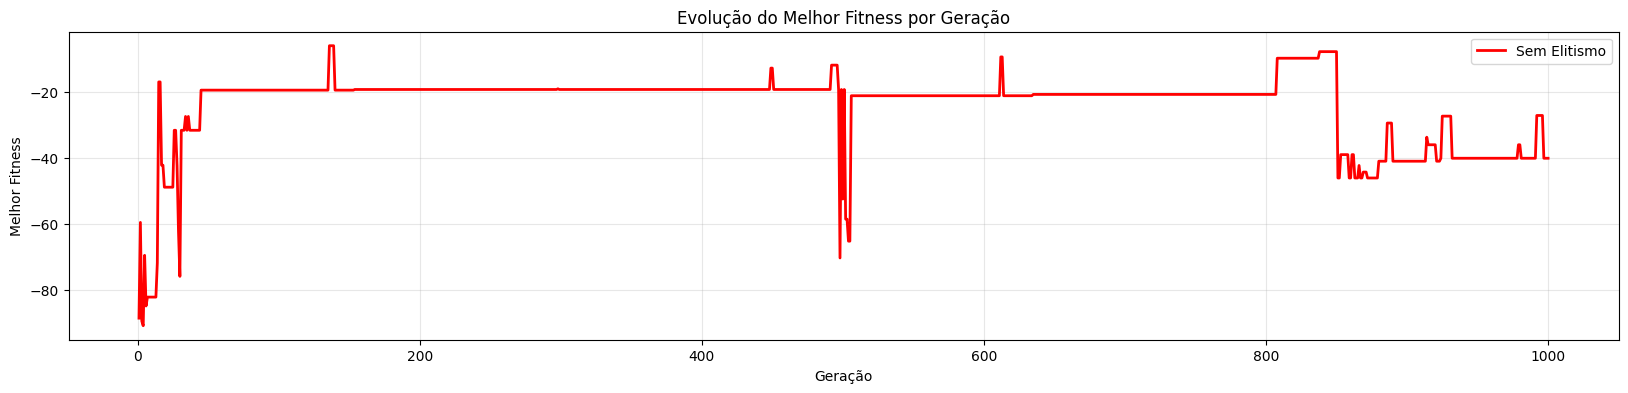

In [343]:
# Plot first algorithm results
displayer.plot_fitness_evolution(
    {"Sem Elitismo": history_basic}, 
    ga_config.num_generations
)

In [344]:
# Run genetic algorithm with elitism
print("\nExecutando algoritmo genético com elitismo...")
best_elitism, fitness_elitism, history_elitism = ga.evolve(
    initial_population, use_elitism=True, mutation_type="meal"
)

displayer.print_meal_plan_results(
    best_elitism, df_alimentos, nutritional_targets.to_dict(), fitness_elitism
)


Executando algoritmo genético com elitismo...

Melhor cardápio:
cafe: Cereais, milho, flocos, sem sal; Feijão, preto, cru; Melão, cru
almoco: Carne, bovina, capa de contra-filé, com gordura, crua; Pastel, de carne, cru; Hambúrguer, bovino, cru
jantar: Azeitona, preta, conserva; Tamarindo, cru; Abacate, cru

Nutrientes:
Energia..kcal.: 2003.00 (meta: 2000.00)
Proteína..g.: 77.60 (meta: 75.00)
Carboidrato..g.: 276.90 (meta: 275.00)
Lipídeos..g.: 71.60 (meta: 70.00)

Fitness final: -9.10


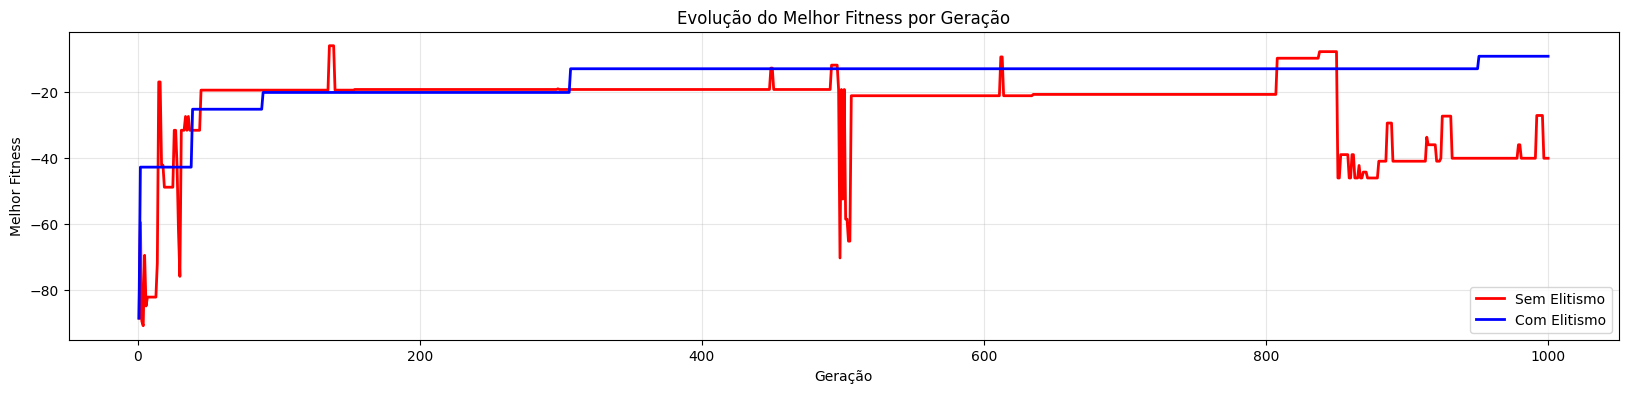

In [345]:
# Compare basic vs elitism
displayer.plot_fitness_evolution(
    {
        "Sem Elitismo": history_basic,
        "Com Elitismo": history_elitism
    }, 
    ga_config.num_generations
)

In [346]:
# Run genetic algorithm with elitism and food-level mutation
print("\nExecutando algoritmo genético com elitismo e mutação por alimento...")
best_elitism_food, fitness_elitism_food, history_elitism_food = ga.evolve(
    initial_population, use_elitism=True, mutation_type="food"
)

displayer.print_meal_plan_results(
    best_elitism_food, df_alimentos, nutritional_targets.to_dict(), fitness_elitism_food
)


Executando algoritmo genético com elitismo e mutação por alimento...

Melhor cardápio:
cafe: Carne, bovina, picanha, sem gordura, grelhada; Bolo, pronto, chocolate; Caruru, cru
almoco: Ameixa, crua; Nhoque, batata, cozido; Hambúrguer, bovino, grelhado
jantar: Chocolate, meio amargo; Arroz, tipo 2, cru; Jamelão, cru

Nutrientes:
Energia..kcal.: 2000.00 (meta: 2000.00)
Proteína..g.: 73.80 (meta: 75.00)
Carboidrato..g.: 274.60 (meta: 275.00)
Lipídeos..g.: 75.00 (meta: 70.00)

Fitness final: -6.60


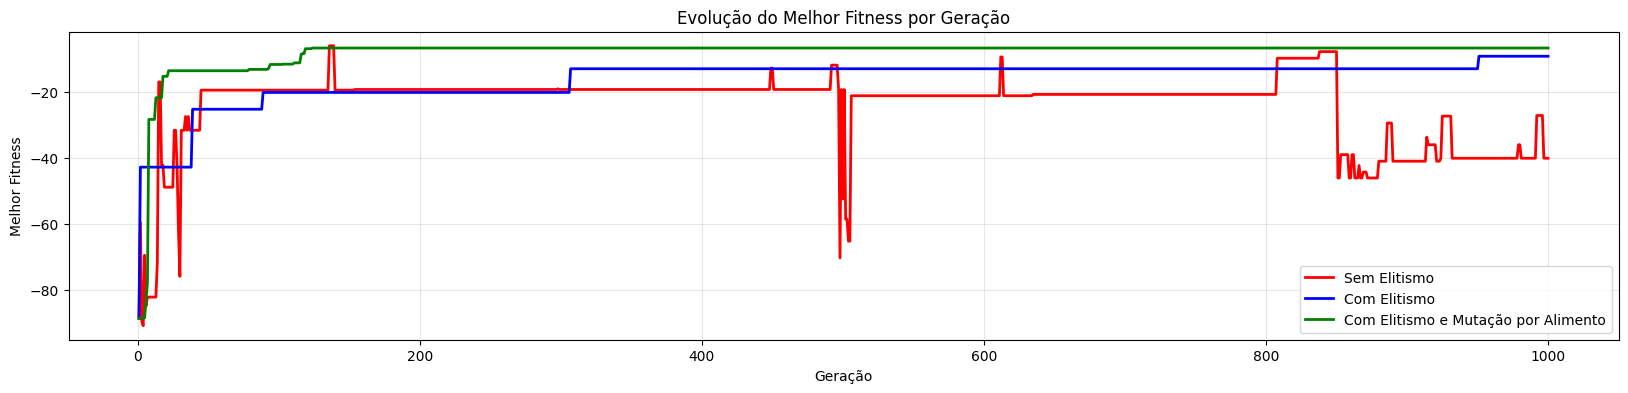

In [347]:
# Final comparison of all three approaches
displayer.plot_fitness_evolution(
    {
        "Sem Elitismo": history_basic,
        "Com Elitismo": history_elitism,
        "Com Elitismo e Mutação por Alimento": history_elitism_food
    }, 
    ga_config.num_generations
)

In [348]:
# Summary of results
print("\n" + "="*50)
print("RESUMO DOS RESULTADOS")
print("="*50)

results = [
    ("Algoritmo Básico", best_basic, fitness_basic),
    ("Com Elitismo", best_elitism, fitness_elitism),
    ("Com Elitismo + Mutação por Alimento", best_elitism_food, fitness_elitism_food)
]

for name, meal_plan, fitness in results:
    print(f"\n{name}:")
    print(f"Fitness: {fitness:.2f}")
    
    nutrients = meal_plan.calculate_nutrients(df_alimentos)
    targets = nutritional_targets.to_dict()
    
    print("Comparação com metas:")
    for nutrient, actual in nutrients.items():
        target = targets[nutrient]
        deviation = abs(actual - target)
        percentage = (1 - deviation / target) * 100 if target > 0 else 0
        print(f"  {nutrient}: {actual:.1f}/{target:.1f} ({percentage:.1f}%)")
    print("-" * 30)


RESUMO DOS RESULTADOS

Algoritmo Básico:
Fitness: -40.10
Comparação com metas:
  Energia..kcal.: 2000.0/2000.0 (100.0%)
  Proteína..g.: 74.8/75.0 (99.7%)
  Carboidrato..g.: 244.9/275.0 (89.1%)
  Lipídeos..g.: 79.8/70.0 (86.0%)
------------------------------

Com Elitismo:
Fitness: -9.10
Comparação com metas:
  Energia..kcal.: 2003.0/2000.0 (99.9%)
  Proteína..g.: 77.6/75.0 (96.5%)
  Carboidrato..g.: 276.9/275.0 (99.3%)
  Lipídeos..g.: 71.6/70.0 (97.7%)
------------------------------

Com Elitismo + Mutação por Alimento:
Fitness: -6.60
Comparação com metas:
  Energia..kcal.: 2000.0/2000.0 (100.0%)
  Proteína..g.: 73.8/75.0 (98.4%)
  Carboidrato..g.: 274.6/275.0 (99.9%)
  Lipídeos..g.: 75.0/70.0 (92.9%)
------------------------------


In [349]:
# Example: How to modify configuration and run custom experiments
print("\n" + "="*50)
print("EXEMPLO: EXPERIMENTAÇÃO CUSTOMIZADA")
print("="*50)

# Create custom configuration
custom_config = GeneticAlgorithmConfig(
    population_size=20,
    num_generations=500,
    mutation_rate=0.3,
    tournament_size=5
)

custom_targets = NutritionalTargets(
    energia_kcal=1800,  # Lower calorie target
    proteina_g=80,      # Higher protein
    carboidrato_g=200,  # Lower carbs
    lipideos_g=60       # Lower fat
)

print(f"Configuração customizada:")
print(f"  População: {custom_config.population_size}")
print(f"  Gerações: {custom_config.num_generations}")
print(f"  Taxa de mutação: {custom_config.mutation_rate}")
print(f"  Tamanho do torneio: {custom_config.tournament_size}")
print(f"\nMetas nutricionais customizadas:")
for nutrient, target in custom_targets.to_dict().items():
    print(f"  {nutrient}: {target}")

# Uncomment to run custom experiment:
# custom_ga = GeneticAlgorithm(df_alimentos, custom_config, custom_targets)
# custom_population = generate_initial_population(df_alimentos, custom_config)
# custom_best, custom_fitness, custom_history = custom_ga.evolve(custom_population, use_elitism=True)


EXEMPLO: EXPERIMENTAÇÃO CUSTOMIZADA
Configuração customizada:
  População: 20
  Gerações: 500
  Taxa de mutação: 0.3
  Tamanho do torneio: 5

Metas nutricionais customizadas:
  Energia..kcal.: 1800
  Proteína..g.: 80
  Carboidrato..g.: 200
  Lipídeos..g.: 60
